In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob 

In [2]:
def analyze_tasks(app_name, droidagent_result_dir):
    task_row = []
    with open(os.path.join(droidagent_result_dir, 'exp_data.json')) as f:
        exp_data = json.load(f)

    task_results = exp_data['task_results']
    for task, task_data in task_results.items():
        num_actions = 0
        for entry in task_data['task_execution_history']:
            if entry['type'] == 'ACTION' and entry['action_data'] is not None:
                num_actions += 1

        task_row.append({
            'app_name': app_name,
            'task': task,
            'success': task_data['result'] == 'SUCCESS',
            'num_actions': num_actions,
            'num_critiques': task_data['num_critiques'],
            'num_visited_pages': len(task_data['visited_pages_during_task']),
        })

    return task_row


task_rows = []
for app_name in os.listdir('../data/'):
    if app_name == "QuickChat":
        continue
    if app_name == '.keep':
        continue
    if app_name == '.DS_Store':
        continue

    result_path = os.path.join('../data/', app_name)

    task_row = analyze_tasks(app_name, result_path)
    task_rows.extend(task_row)

task_df = pd.DataFrame(task_rows)
task_df

,app_name,task,success,num_actions,num_critiques,num_visited_pages
0,Phonograph,"Complete the AppIntro by clicking on the ""GET ...",True,1,0,2
1,Phonograph,Start playing a song from the song list.,True,1,0,1
2,Phonograph,Explore the album details by selecting an albu...,True,4,1,2
3,Phonograph,Edit the tags of the current album on the Albu...,True,13,3,3
4,Phonograph,Set a sleep timer for the current playing album.,True,4,1,1
...,...,...,...,...,...,...
542,Omni-Notes,Set a password for the notes to secure them.,False,13,3,1
543,Omni-Notes,Navigate to the Gallery page to view attached ...,False,13,3,1
544,Omni-Notes,"Add a new tag ""Study Material"" to the note tit...",False,13,3,1
545,Omni-Notes,"Add a new tag ""CS Studies"" to the note titled ...",False,13,3,1


In [3]:
manual_assessments = glob.glob('../task_assessment/manual_assessment*.csv')
manual_assessments

['../task_assessment/manual_assessment_openlauncher.csv',
 '../task_assessment/manual_assessment_AntennaPod.csv',
 '../task_assessment/manual_assessment_commons.csv',
 '../task_assessment/manual_assessment_collect.csv',
 '../task_assessment/manual_assessment_osmeditor4android.csv',
 '../task_assessment/manual_assessment_Phonograph.csv',
 '../task_assessment/manual_assessment_APhotoManager.csv',
 '../task_assessment/manual_assessment_Scarlet-Notes.csv',
 '../task_assessment/manual_assessment_AnkiDroid.csv',
 '../task_assessment/manual_assessment_MyExpenses.csv',
 '../task_assessment/manual_assessment_Markor.csv',
 '../task_assessment/manual_assessment_MaterialFB.csv',
 '../task_assessment/manual_assessment_Omni-Notes.csv',
 '../task_assessment/manual_assessment_ActivityDiary.csv',
 '../task_assessment/manual_assessment_OpenTracks.csv']

In [4]:
def clean_nonascii_chars(text):
    return ''.join([i if ord(i) < 128 else ' ' for i in text])

task_df['task'] = task_df['task'].apply(clean_nonascii_chars)

In [5]:
for manual_label in manual_assessments:
    app_name = os.path.basename(manual_label).split('.')[0].split('_')[-1]
    if app_name == "QuickChat":
        continue
    df = pd.read_csv(manual_label, encoding = "ISO-8859-1")
    if 'duplicated' not in df.columns:
        print('No duplicated column: ', app_name)
        break
    # fill NaN with empty string 
    df = df.fillna('')
    for i, row in df.iterrows():
        task = clean_nonascii_chars(row['task'])
        if len(task_df.loc[(task_df['app_name'] == app_name) & (task_df['task'] == task)]) == 0:
            print('Task not found: ', app_name, task)

        task_df.loc[(task_df['app_name'] == app_name) & (task_df['task'] == task), 'manual_success'] = row['manual_result'].strip() == 'SUCCESS'
        task_df.loc[(task_df['app_name'] == app_name) & (task_df['task'] == task), 'is_possible'] = 'X' not in row['is_possible_task']
        task_df.loc[(task_df['app_name'] == app_name) & (task_df['task'] == task), 'duplicated'] = 'O' in row['duplicated']


/var/folders/nn/kfc9twsx3kq0b3xmpb25k5w40000gn/T/ipykernel_12923/2509120802.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  task_df.loc[(task_df['app_name'] == app_name) & (task_df['task'] == task), 'manual_success'] = row['manual_result'].strip() == 'SUCCESS'
/var/folders/nn/kfc9twsx3kq0b3xmpb25k5w40000gn/T/ipykernel_12923/2509120802.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  task_df.loc[(task_df['app_name'] == app_name) & (task_df['task'] == task), 'is_possible'] = 'X' not in row['is_possible_task']
/var/folders/nn/kfc9twsx3kq0b3xmpb25k5w40000gn/T/ipykernel_12923/2509120802.py:18: FutureWarning: Setting an item of incompatible dtype is d

In [6]:
task_df['manual_success_unique'] = task_df['manual_success'] & ~task_df['duplicated']
task_df['is_possible_unique'] = task_df['is_possible'] & ~task_df['duplicated']
task_df['task_count_unique'] = 1 -task_df['duplicated']
task_df

,app_name,task,success,num_actions,num_critiques,num_visited_pages,manual_success,is_possible,duplicated,manual_success_unique,is_possible_unique,task_count_unique
0,Phonograph,"Complete the AppIntro by clicking on the ""GET ...",True,1,0,2,True,True,False,True,True,1
1,Phonograph,Start playing a song from the song list.,True,1,0,1,True,True,False,True,True,1
2,Phonograph,Explore the album details by selecting an albu...,True,4,1,2,True,True,False,True,True,1
3,Phonograph,Edit the tags of the current album on the Albu...,True,13,3,3,True,True,False,True,True,1
4,Phonograph,Set a sleep timer for the current playing album.,True,4,1,1,True,True,False,True,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...
542,Omni-Notes,Set a password for the notes to secure them.,False,13,3,1,True,True,False,True,True,1
543,Omni-Notes,Navigate to the Gallery page to view attached ...,False,13,3,1,False,True,False,False,True,1
544,Omni-Notes,"Add a new tag ""Study Material"" to the note tit...",False,13,3,1,False,True,True,False,False,0
545,Omni-Notes,"Add a new tag ""CS Studies"" to the note titled ...",False,13,3,1,False,True,True,False,False,0


In [7]:
task_df.manual_success.value_counts()

manual_success
True     296
False    251
Name: count, dtype: int64

In [8]:
# assign task count 
task_df['task_count'] = 1

task_df_agg = task_df.groupby('app_name').sum()
task_df_agg

,task,success,num_actions,num_critiques,num_visited_pages,manual_success,is_possible,duplicated,manual_success_unique,is_possible_unique,task_count_unique,task_count
app_name,,,,,,,,,,,,
APhotoManager,View the details of a photo.Edit the EXIF data...,15,348,74,59,11,36,19,8,17,22,41
ActivityDiary,Add a new activity to the diary.Check the stat...,25,317,63,68,22,37,15,16,22,23,38
AnkiDroid,Synchronize the existing AnkiDroid account wit...,26,415,87,95,23,42,13,20,29,31,44
AntennaPod,Add a new podcast to the app.Mark an episode a...,29,331,67,53,24,36,14,19,27,31,45
Markor,Navigate to the Main page by scrolling through...,12,255,52,36,19,26,4,15,22,24,28
MaterialFB,Log into the MaterialFBook app using the given...,9,248,53,30,9,16,4,8,12,20,24
MyExpenses,Change the app theme to Dark and set the trans...,21,358,74,102,23,37,16,15,22,26,42
Omni-Notes,Create a new note in the Omni Notes Alpha app....,10,294,61,45,15,34,10,13,24,24,34
OpenTracks,Proceed to the next page from the Introduction...,31,287,54,105,32,37,15,21,22,23,38


In [9]:
task_df_agg.reset_index(inplace=True)
rows = []

for i, row in task_df_agg.iterrows():
    rows.append({
        'app_name': row['app_name'],
        'task_count': row['task_count'],
        'percentage': 100,
        'type': 'Total'
    })

    rows.append({
        'app_name': row['app_name'],
        'task_count': row['task_count_unique'],
        'percentage': row['task_count_unique'] / row['task_count'] * 100,
        'type': 'Total (Unique)'
    })

    rows.append({
        'app_name': row['app_name'],
        'task_count': row['is_possible_unique'],
        'percentage': row['is_possible_unique'] / row['task_count_unique'] * 100,
        'type': 'Possible'
    })

    rows.append({
        'app_name': row['app_name'],
        'task_count': row['manual_success_unique'],
        'percentage': row['manual_success_unique'] / row['task_count_unique'] * 100,
        'type': 'Successful'
    })

task_df_agg = df = pd.DataFrame(rows)
task_df_agg

,app_name,task_count,percentage,type
0,APhotoManager,41,100.000000,Total
1,APhotoManager,22,53.658537,Total (Unique)
2,APhotoManager,17,77.272727,Possible
3,APhotoManager,8,36.363636,Successful
4,ActivityDiary,38,100.000000,Total
5,ActivityDiary,23,60.526316,Total (Unique)
6,ActivityDiary,22,95.652174,Possible
7,ActivityDiary,16,69.565217,Successful
8,AnkiDroid,44,100.000000,Total
9,AnkiDroid,31,70.454545,Total (Unique)


/var/folders/nn/kfc9twsx3kq0b3xmpb25k5w40000gn/T/ipykernel_12923/303648395.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=80, ha="right")


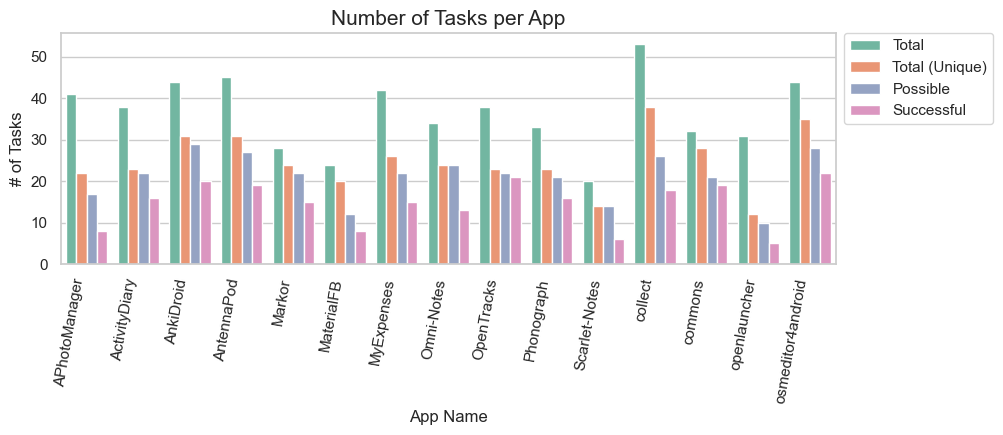

In [10]:
# bar graph (is_possible, task_count)

sns.set(style="whitegrid")
# figure size
plt.figure(figsize=(10, 3))
ax = sns.barplot(x="app_name", y="task_count", hue="type", data=task_df_agg, palette="Set2")
ax.set_xticklabels(ax.get_xticklabels(), rotation=80, ha="right")
ax.set_xlabel('App Name')
ax.set_ylabel('# of Tasks')
ax.set_title('Number of Tasks per App', fontsize=15)
# change legend position
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

In [11]:
task_df_mean = task_df_agg.groupby('type')[['task_count', 'percentage']].mean()

task_df_mean.reset_index(inplace=True)

# reorder rows 
task_df_mean = task_df_mean.reindex([2, 3, 0, 1])
task_df_mean

,type,task_count,percentage
2,Total,36.466667,100.000000
3,Total (Unique),24.933333,68.849696
0,Possible,21.133333,85.570868
1,Successful,14.733333,57.971357


In [12]:
task_df_sum = task_df_agg.groupby('type')[['task_count', 'percentage']].sum()

task_df_sum.reset_index(inplace=True)

# reorder rows 
task_df_sum = task_df_sum.reindex([2, 3, 0, 1])
task_df_sum

,type,task_count,percentage
2,Total,547,1500.000000
3,Total (Unique),374,1032.745434
0,Possible,317,1283.563021
1,Successful,221,869.570361


In [13]:
task_df_sum[task_df_sum['type'] == 'Possible'].task_count.values[0] / task_df_sum[task_df_sum['type'] == 'Total (Unique)'].task_count.values[0]
#317/374

0.8475935828877005

In [14]:
task_df_sum[task_df_sum['type'] == 'Successful'].task_count.values[0] / task_df_sum[task_df_sum['type'] == 'Total (Unique)'].task_count.values[0]

0.5909090909090909

/var/folders/nn/kfc9twsx3kq0b3xmpb25k5w40000gn/T/ipykernel_12923/751751120.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="type", y="task_count", data=task_df_agg, palette="Set2", order=['Total (Unique)', 'Possible', 'Completed'], errorbar="sd", legend=False)


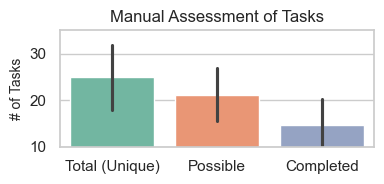

In [15]:
# Need aggregated results (all apps)

# bar graph (manual_success, task_count)
plt.figure(figsize=(4, 2))

# text size
sns.set(font_scale=1.0)
sns.set_style("whitegrid")

# rename type name "Successful" to "Completed"
task_df_agg['type'] = task_df_agg['type'].replace('Successful', 'Completed')
ax = sns.barplot(x="type", y="task_count", data=task_df_agg, palette="Set2", order=['Total (Unique)', 'Possible', 'Completed'], errorbar="sd", legend=False)
ax.set_xlabel('', fontsize=10)
ax.set_ylabel('# of Tasks', fontsize=10)
ax.set_ylim(10, 35)
ax.set_title('Manual Assessment of Tasks')

plt.tight_layout()
plt.savefig('./figures/RQ2_task_manual_assessment.pdf')
plt.show()

In [16]:
%pip install scikit-learn
sns.set_theme(style="whitegrid")

# classification accuracy of success vs. manual success

predicted = task_df['success'].values.astype(int)
manual = task_df['manual_success'].values.astype(int)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(classification_report(manual, predicted, target_names=['Success', 'Failure']))


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
              precision    recall  f1-score   support

     Success       0.72      0.77      0.74       251
     Failure       0.79      0.74      0.77       296

    accuracy                           0.76       547
   macro avg       0.76      0.76      0.76       547
weighted avg       0.76      0.76      0.76       547



In [17]:
confusion_matrix(manual, predicted)

array([[194,  57],
       [ 76, 220]])